In [1]:
import numpy as np
data_directory = "../testDataIP/"
import matplotlib.pyplot as plt

In [2]:
time_gates = "30:50,50:70,70:100,100:130,130:170,170:210,210:260,260:320,320:390,390:470,470:560,560:660,660:770,770:890"
data = "0.780       0.626       0.522       0.456       0.401       0.347       0.309       0.273       0.236       0.208       0.180       0.155       0.135       0.124"
Vp = 24.388
time_gates = np.array([np.array(gate.split(":"), dtype=float) for gate in time_gates.split(',')])
data = np.array(data.split(), dtype=float)
times = np.sqrt(time_gates[:,0] * time_gates[:,1]) * 1e-3


Text(0,0.5,'Voltage (mV/V)')

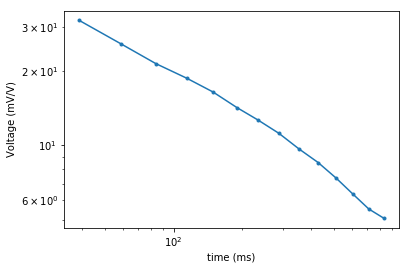

In [3]:
plt.loglog(times*1e3, data/Vp * 1e3, '.-')
plt.xlabel("time (ms)")
plt.ylabel("Voltage (mV/V)")

In [4]:
from simpegEMIP.StretchedExponential import SEInvProblem, SESurvey
from SimPEG import *
def fit_with_se(time, dobs, eta0=0.01, tau0=0.1, c0=0.5):
    siginf = 1.
    wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
    taumap = Maps.ExpMap(nP=1)*wires.tau
    etamap = Maps.ExpMap(nP=1)*wires.eta
    cmap = Maps.ExpMap(nP=1)*wires.c    
    survey = SESurvey()
    survey.dobs = dobs
    m1D = Mesh.TensorMesh([np.ones(3)])
    prob = SEInvProblem(m1D, etaMap = etamap, tauMap = taumap, cMap=cmap)
    prob.time = time
    prob.pair(survey)
    eta0 = dobs[1]
    m0 = np.log(np.r_[eta0, tau0, c0])
    perc = 0.05
    dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
    dmisfitpeta.W = 1/(abs(survey.dobs)*perc)
    reg = Regularization.Simple(m1D)
    opt = Optimization.ProjectedGNCG(maxIter = 10)
    invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
    target = Directives.TargetMisfit()
    betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
    opt.upper = np.log(np.r_[1., 10., 1.])
    opt.lower = np.log(np.r_[1e-5, 0.001, 1e-2])
    
    invProb.beta=0.
    inv = Inversion.BaseInversion(invProb, directiveList=[target])
    reg.mref = 0.*m0
    prob.counter = opt.counter = Utils.Counter()
    opt.LSshorten = 0.5
    opt.remember('xc')
    opt.tolX = 1e-20
    opt.tolF = 1e-20
    opt.tolG = 1e-20
    opt.eps = 1e-20
    mopt = inv.run(m0)   
    return np.exp(mopt), survey.dobs, invProb.dpred

mopt, dobs, dpred = fit_with_se(times, data/Vp)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  9.90e+02  1.18e+01  9.90e+02    7.07e+00      0              
   1  0.00e+00  7.13e+02  7.17e+00  7.13e+02    1.01e+01      0              
   2  0.00e+00  5.54e+01  8.43e+00  5.54e+01    9.79e+00      0              
   3  0.00e+00  4.46e+01  9.34e+00  4.46e+01    9.72e+00      2              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 9.9086e-18
0 : |xc-x_last| = 2.7431e-01 <= tolX*(1+|x0|) = 5.3814e-20
0 : |proj(x-g)-x|    = 9.8067

eta: 6.0e-02, tau: 8.6e-02, c: 4.1e-01


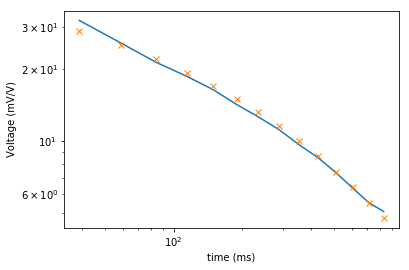

In [5]:
plt.loglog(times*1e3, dobs * 1e3, '-')
plt.loglog(times*1e3, dpred * 1e3, 'x')
plt.xlabel("time (ms)")
plt.ylabel("Voltage (mV/V)")
print (("eta: %.1e, tau: %.1e, c: %.1e") % (mopt[0], mopt[1], mopt[2]))

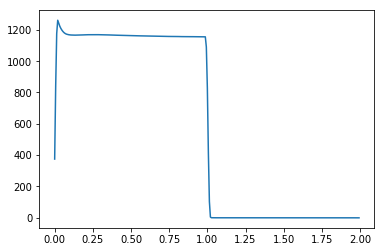

In [6]:
current = np.loadtxt(data_directory+"P0-R110-In.xyz")
dt = 1./150.
plt.plot(current[:,0]*dt, current[:,1])

Text(0,0.5,'Current (mA)')

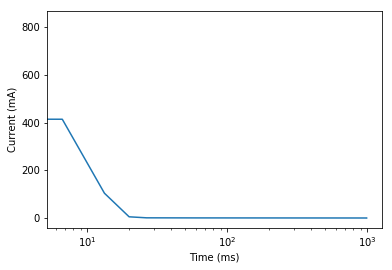

In [7]:
plt.semilogx((current[150:,0]*dt-1)*1e3, current[150:,1])
plt.xlabel("Time (ms)")
plt.ylabel("Current (mA)")

Text(0,0.5,'Current (mA)')

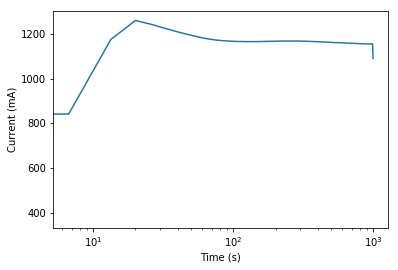

In [9]:
plt.semilogx(current[:150,0]*dt*1e3, current[:150,1])
plt.xlabel("Time (s)")
plt.ylabel("Current (mA)")